<a href="https://colab.research.google.com/github/melvinDrose/ai-zero2-job/blob/main/notebooks/02_clean_and_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!apt-get -qq update
!apt-get -qq install -y fonts-noto-cjk fonts-wqy-zenhei
!rm -rf ~/.cache/matplotlib


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126718 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Selecting previously unselected package fonts-wqy-zenhei.
Preparing to unpack .../fonts-wqy-zenhei_0.9.45-8_all.deb ...
Unpacking fonts-wqy-zenhei (0.9.45-8) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-wqy-zenhei (0.9.45-8) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [4]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 依次尝试常见字体文件路径，找到就用
candidates = [
    "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc",
    "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",
    "/usr/share/fonts/truetype/noto/NotoSerifCJK-Regular.ttc",
    "/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc",
]
font_path = next((p for p in candidates if os.path.exists(p)), None)
assert font_path, "没找到中文字体文件；运行 `!fc-list :lang=zh` 把输出发我"

# 注册并设为默认
fm.fontManager.addfont(font_path)
font_name = fm.FontProperties(fname=font_path).get_name()
mpl.rcParams["font.family"] = font_name
mpl.rcParams["axes.unicode_minus"] = False  # 负号不乱码
print("✅ 正在使用中文字体：", font_name, " @ ", font_path)

✅ 正在使用中文字体： Noto Sans CJK JP  @  /usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc


In [5]:
# === 载入数据（用你的 Sheet 导出为 CSV 的直链）===
import pandas as pd, unicodedata as ud

sheet_id = "1qW7c5rqbGDHSLuWk6RetPdz4QxPN3zXZgRz3LZA9xt4"  # 换成你的
gid = "0"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

df_raw = pd.read_csv(url)
df = df_raw.copy()

# ---- 清洗 1：文本规范化（category）----
# 做的事：全角/半角统一、去首尾空格、常见同义词合并
def norm_text(x: str) -> str:
    if pd.isna(x): return ""
    x = ud.normalize("NFKC", str(x)).strip()  # 全角转半角 + 去空格
    return x

df["category"] = df["category"].map(norm_text)

# 常见同义词映射（按你的实际数据随时增补）
syn = {
    "退货": "退款",
    "品质": "质量",
    "登陆": "登录",
    "账户": "账号",
    "发 货": "发货",
}
df["category"] = df["category"].replace(syn)

# ---- 清洗 2：数值与日期校验（amount/date）----
# 1) 日期转为datetime；2) 金额转 numeric（坏数据→NaN），去重/去缺失；3) 极端值裁剪（99分位）
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

df["amount"] = pd.to_numeric(df["amount"], errors="coerce")
df = df.drop_duplicates().dropna(subset=["amount", "category"])
if "date" in df.columns:
    df = df.dropna(subset=["date"])

# 极端值裁剪（Winsorize）：把过大的异常值顶到 P99，避免一两个异常点拉歪图
p99 = df["amount"].quantile(0.99)
df["amount"] = df["amount"].clip(upper=p99)

print("✅ 清洗完成：", df.shape)
display(df.head())


✅ 清洗完成： (10, 3)


,date,category,amount
0,2025-01-01,退款,12.111
1,2025-01-01,发货,5.000
2,2025-01-02,质量,8.800
3,2025-01-03,账号,3.500
4,2025-01-03,退款,7.200


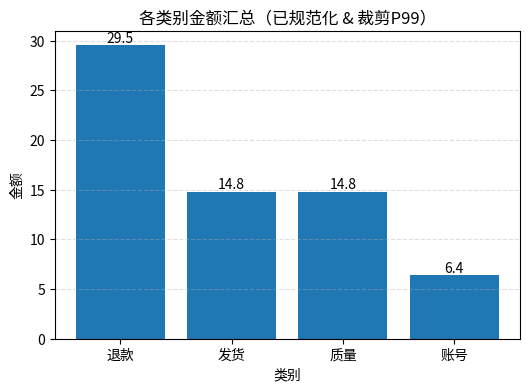

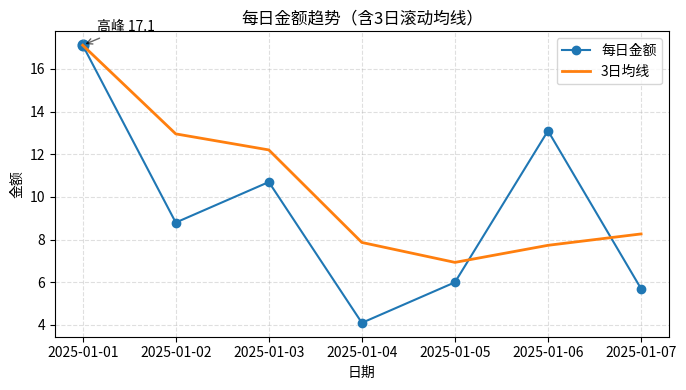

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# —— 图 1：各类别金额柱状图（降序 + 顶部数字标签）
by_cat = (
    df.groupby("category", as_index=False)["amount"]
      .sum()
      .sort_values("amount", ascending=False)
)

plt.figure(figsize=(6,4))
bars = plt.bar(by_cat["category"], by_cat["amount"])
plt.title("各类别金额汇总（已规范化 & 裁剪P99）")
plt.xlabel("类别"); plt.ylabel("金额")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.xticks(rotation=0)

# 顶部数据标签
for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h, f"{h:.1f}", ha="center", va="bottom", fontsize=10)
plt.show()

# —— 图 2：每日金额趋势 + 3日滚动均线 & 高峰标注
by_day = df.groupby("date", as_index=False)["amount"].sum().sort_values("date")
by_day["roll3"] = by_day["amount"].rolling(3, min_periods=1).mean()

plt.figure(figsize=(7,4))
plt.plot(by_day["date"], by_day["amount"], marker="o", label="每日金额")
plt.plot(by_day["date"], by_day["roll3"], linewidth=2, label="3日均线")
plt.title("每日金额趋势（含3日滚动均线）")
plt.xlabel("日期"); plt.ylabel("金额"); plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="best")

# 标注峰值
imax = by_day["amount"].idxmax()
x0, y0 = by_day.loc[imax, "date"], by_day.loc[imax, "amount"]
plt.scatter([x0], [y0], s=60)
plt.annotate(f"高峰 {y0:.1f}", xy=(x0, y0), xytext=(10,10),
             textcoords="offset points", arrowprops=dict(arrowstyle="->", alpha=0.6))
plt.tight_layout()
plt.show()


In [7]:
from textwrap import dedent

date_min = df["date"].min().date() if "date" in df.columns else "N/A"
date_max = df["date"].max().date() if "date" in df.columns else "N/A"
total_amt = df["amount"].sum()

top_row = by_cat.iloc[0] if len(by_cat)>0 else None
top_cat, top_amt = (top_row["category"], top_row["amount"]) if top_row is not None else ("N/A", 0)

peak_row = by_day.iloc[by_day["amount"].argmax()] if len(by_day)>0 else None
peak_day, peak_val = (peak_row["date"].date(), peak_row["amount"]) if peak_row is not None else ("N/A", 0)

report = dedent(f"""
【迷你周报 | 文本路由数据】
- 覆盖周期：{date_min} ~ {date_max}
- 总金额：{total_amt:.1f}
- 最高类别：{top_cat}（{top_amt:.1f}）
- 高峰日期：{peak_day}（{peak_val:.1f}）
- 本周观察：① 类别“{top_cat}”占比较高，建议优先优化其自动分流规则；
           ② 非高峰日波动较小，3日均线平稳，可继续观察下周是否有新峰值。
""").strip()

print(report)


【迷你周报 | 文本路由数据】
- 覆盖周期：2025-01-01 ~ 2025-01-07
- 总金额：65.5
- 最高类别：退款（29.5）
- 高峰日期：2025-01-01（17.1）
- 本周观察：① 类别“退款”占比较高，建议优先优化其自动分流规则；
           ② 非高峰日波动较小，3日均线平稳，可继续观察下周是否有新峰值。
